# Exploring metrics after training

With this example, we dive deeper into our results and compare each partner performance against the federated model

In [1]:
# imports
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

# Object and methodes needed in order to run a collaborative round
from subtest.dataset import Dataset
from subtest.scenario import Scenario, run_scenario

Using TensorFlow backend.


## Setup scenario

In [2]:
scenario_params = {
    'partners_count': 3,
    'amounts_per_partner': [0.001, 0.699, 0.3],
}

scenario_params['epoch_count'] = 10
scenario_params['minibatch_count'] = 3

# Chose the contributivity mesuring method

In [3]:
# Here is the difference
scenario_params['methods'] = ["Shapley values"]

In [4]:
current_scenario = Scenario(scenario_params)

2020-08-19 13:52:30.910 | DEBUG    | subtest.scenario:__init__:54 - Dataset selected: mnist
2020-08-19 13:52:30.910 | DEBUG    | subtest.scenario:__init__:89 - Computation use the full dataset for scenario #1
2020-08-19 13:52:30.975 | INFO     | subtest.scenario:__init__:281 - ### Description of data scenario configured:
2020-08-19 13:52:30.976 | INFO     | subtest.scenario:__init__:282 -    Number of partners defined: 3
2020-08-19 13:52:30.976 | INFO     | subtest.scenario:__init__:283 -    Data distribution scenario chosen: random
2020-08-19 13:52:30.977 | INFO     | subtest.scenario:__init__:284 -    Multi-partner learning approach: fedavg
2020-08-19 13:52:30.977 | INFO     | subtest.scenario:__init__:285 -    Weighting option: uniform
2020-08-19 13:52:30.977 | INFO     | subtest.scenario:__init__:286 -    Iterations parameters: 10 epochs > 3 mini-batches > 8 gradient updates per pass
2020-08-19 13:52:30.978 | INFO     | subtest.scenario:__init__:292 - ### Data loaded: mnist
2020-08

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0],  28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

input_shape = (28, 28, 1)
num_classes = 10


def preprocess_dataset_labels(y):
    y = np_utils.to_categorical(y, 10)
    return y


def generate_new_model_for_dataset():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2))) 
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(64, activation='relu'))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


current_scenario.dataset = Dataset(
    "my_dataset",
    X_train,
    X_test,
    y_train,
    y_test,
    input_shape,
    num_classes,
    preprocess_dataset_labels,
    generate_new_model_for_dataset
)


current_scenario.dataset.train_val_split()

In [6]:
run_scenario(current_scenario)

2020-08-19 13:52:31.570 | INFO     | subtest.scenario:split_data:536 - ### Splitting data among partners:
2020-08-19 13:52:31.571 | INFO     | subtest.scenario:split_data:537 -    Simple split performed.
2020-08-19 13:52:31.571 | INFO     | subtest.scenario:split_data:538 -    Nb of samples split amongst partners: 38878
2020-08-19 13:52:31.572 | INFO     | subtest.scenario:split_data:540 -    Partner #0: 38 samples with labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-08-19 13:52:31.572 | INFO     | subtest.scenario:split_data:540 -    Partner #1: 27176 samples with labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-08-19 13:52:31.573 | INFO     | subtest.scenario:split_data:540 -    Partner #2: 11664 samples with labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2020-08-19 13:52:31.840 | DEBUG    | subtest.scenario:compute_batch_sizes:584 -    Compute batch sizes, partner #0: 1
2020-08-19 13:52:31.841 | DEBUG    | subtest.scenario:compute_batch_sizes:584 -    Compute batch sizes, partner #1: 1132
2020-08-19 13

2020-08-19 13:55:04.931 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > Minibatch 02/02 > Partner id #1 (1/2) > val_acc: 0.88
2020-08-19 13:55:05.556 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > Minibatch 02/02 > Partner id #2 (2/2) > val_acc: 0.88
2020-08-19 13:55:05.559 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 13:55:05.829 | INFO     | subtest.multi_partner_learning:compute_test_score:184 -    Model evaluation at the end of the epoch: ['0.492', '0.844']
2020-08-19 13:55:05.830 | DEBUG    | subtest.multi_partner_learning:compute_test_score:187 -       Checking if early stopping criteria are met:
2020-08-19 13:55:05.831 | DEBUG    | subtest.multi_partner_learning:compute_test_score:197 -          -> Early stopping criteria are not met, continuing with training.
2020-08-19 13:55:05.888 |

2020-08-19 13:57:44.408 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 13:57:44.409 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°0 of epoch n°4, init aggregated model for each partner with models from previous round
2020-08-19 13:58:09.194 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 04/09 > Minibatch 00/02 > Partner id #0 (0/2) > val_acc: 0.77
2020-08-19 13:58:10.002 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 04/09 > Minibatch 00/02 > Partner id #1 (1/2) > val_acc: 0.93
2020-08-19 13:58:10.671 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 04/09 > Minibatch 00/02 > Partner id #2 (2/2) > val_acc: 0.92
2020-08-19 13:58:10.674 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_

2020-08-19 14:00:44.726 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:00:44.726 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°1 of epoch n°6, init aggregated model for each partner with models from previous round
2020-08-19 14:01:08.632 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 01/02 > Partner id #0 (0/2) > val_acc: 0.83
2020-08-19 14:01:10.459 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 01/02 > Partner id #1 (1/2) > val_acc: 0.96
2020-08-19 14:01:11.212 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 01/02 > Partner id #2 (2/2) > val_acc: 0.96
2020-08-19 14:01:11.215 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_

2020-08-19 14:04:51.063 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:04:51.063 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°2 of epoch n°8, init aggregated model for each partner with models from previous round
2020-08-19 14:05:17.312 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 02/02 > Partner id #0 (0/2) > val_acc: 0.88
2020-08-19 14:05:18.260 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 02/02 > Partner id #1 (1/2) > val_acc: 0.97
2020-08-19 14:05:19.031 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 02/02 > Partner id #2 (2/2) > val_acc: 0.97
2020-08-19 14:05:19.034 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_

2020-08-19 14:12:34.623 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 00/09 > Minibatch 00/02 > Partner id #0 (0/1) > val_acc: 0.17
2020-08-19 14:12:36.107 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 00/09 > Minibatch 00/02 > Partner id #1 (1/1) > val_acc: 0.72
2020-08-19 14:12:36.111 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:12:36.111 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:12:36.112 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°1 of epoch n°0, init aggregated model for each partner with models from previous round
2020-08-19 14:13:02.309 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 00/09 > 

2020-08-19 14:16:25.115 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:16:25.561 | INFO     | subtest.multi_partner_learning:compute_test_score:184 -    Model evaluation at the end of the epoch: ['0.329', '0.911']
2020-08-19 14:16:25.562 | DEBUG    | subtest.multi_partner_learning:compute_test_score:187 -       Checking if early stopping criteria are met:
2020-08-19 14:16:25.562 | DEBUG    | subtest.multi_partner_learning:compute_test_score:197 -          -> Early stopping criteria are not met, continuing with training.
2020-08-19 14:16:25.607 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:16:25.608 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°0 of epoch n°3, init aggregated model for each partner with models from previous round
2020-08-19 14:16:52.

2020-08-19 14:20:31.933 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 05/09 > Minibatch 01/02 > Partner id #1 (1/1) > val_acc: 0.95
2020-08-19 14:20:31.936 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:20:31.937 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:20:31.937 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°2 of epoch n°5, init aggregated model for each partner with models from previous round
2020-08-19 14:20:59.360 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 05/09 > Minibatch 02/02 > Partner id #0 (0/1) > val_acc: 0.85
2020-08-19 14:21:01.349 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 05/09 > 

2020-08-19 14:24:43.138 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 00/02 > Partner id #0 (0/1) > val_acc: 0.89
2020-08-19 14:24:44.816 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 00/02 > Partner id #1 (1/1) > val_acc: 0.97
2020-08-19 14:24:44.819 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:24:44.819 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:24:44.820 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°1 of epoch n°8, init aggregated model for each partner with models from previous round
2020-08-19 14:25:11.348 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > 

2020-08-19 14:28:04.925 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:28:04.926 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:28:04.927 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°2 of epoch n°0, init aggregated model for each partner with models from previous round
2020-08-19 14:28:31.650 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 00/09 > Minibatch 02/02 > Partner id #0 (0/1) > val_acc: 0.33
2020-08-19 14:28:32.755 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 00/09 > Minibatch 02/02 > Partner id #2 (1/1) > val_acc: 0.78
2020-08-19 14:28:32.758 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg coll

2020-08-19 14:33:07.908 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 03/09 > Minibatch 00/02 > Partner id #2 (1/1) > val_acc: 0.91
2020-08-19 14:33:07.912 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:33:07.912 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:33:07.913 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°1 of epoch n°3, init aggregated model for each partner with models from previous round
2020-08-19 14:33:34.810 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 03/09 > Minibatch 01/02 > Partner id #0 (0/1) > val_acc: 0.72
2020-08-19 14:33:35.792 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 03/09 > 

2020-08-19 14:37:07.689 | INFO     | subtest.multi_partner_learning:compute_test_score:184 -    Model evaluation at the end of the epoch: ['0.285', '0.913']
2020-08-19 14:37:07.690 | DEBUG    | subtest.multi_partner_learning:compute_test_score:187 -       Checking if early stopping criteria are met:
2020-08-19 14:37:07.691 | DEBUG    | subtest.multi_partner_learning:compute_test_score:197 -          -> Early stopping criteria are not met, continuing with training.
2020-08-19 14:37:07.712 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:37:07.713 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°0 of epoch n°6, init aggregated model for each partner with models from previous round
2020-08-19 14:37:34.404 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 00/02 > Partner id #0 (0/1)

2020-08-19 14:40:58.445 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:40:58.446 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:40:58.446 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°2 of epoch n°8, init aggregated model for each partner with models from previous round
2020-08-19 14:41:26.683 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 02/02 > Partner id #0 (0/1) > val_acc: 0.8
2020-08-19 14:41:27.654 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 02/02 > Partner id #2 (1/1) > val_acc: 0.96
2020-08-19 14:41:27.658 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg colla

2020-08-19 14:43:07.245 | DEBUG    | subtest.multi_partner_learning:compute_test_score:197 -          -> Early stopping criteria are not met, continuing with training.
2020-08-19 14:43:07.306 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:43:07.307 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°0 of epoch n°1, init aggregated model for each partner with models from previous round
2020-08-19 14:43:09.058 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > Minibatch 00/02 > Partner id #1 (0/1) > val_acc: 0.87
2020-08-19 14:43:10.211 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > Minibatch 00/02 > Partner id #2 (1/1) > val_acc: 0.87
2020-08-19 14:43:10.214 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:

2020-08-19 14:43:35.934 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°2 of epoch n°3, init aggregated model for each partner with models from previous round
2020-08-19 14:43:41.809 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 03/09 > Minibatch 02/02 > Partner id #1 (0/1) > val_acc: 0.95
2020-08-19 14:43:44.674 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 03/09 > Minibatch 02/02 > Partner id #2 (1/1) > val_acc: 0.95
2020-08-19 14:43:44.677 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:43:45.096 | INFO     | subtest.multi_partner_learning:compute_test_score:184 -    Model evaluation at the end of the epoch: ['0.148', '0.958']
2020-08-19 14:43:45.096 | DEBUG    | subtest.multi_partner_learning:compute_test_score:187 -       Checking if early sto

2020-08-19 14:44:39.649 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:44:39.649 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°1 of epoch n°6, init aggregated model for each partner with models from previous round
2020-08-19 14:44:43.763 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 01/02 > Partner id #1 (0/1) > val_acc: 0.97
2020-08-19 14:44:44.839 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 06/09 > Minibatch 01/02 > Partner id #2 (1/1) > val_acc: 0.97
2020-08-19 14:44:44.842 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:44:44.842 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg c

2020-08-19 14:45:38.895 | DEBUG    | subtest.multi_partner_learning:compute_test_score:197 -          -> Early stopping criteria are not met, continuing with training.
2020-08-19 14:45:38.956 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:45:38.956 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°0 of epoch n°9, init aggregated model for each partner with models from previous round
2020-08-19 14:45:43.512 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 09/09 > Minibatch 00/02 > Partner id #1 (0/1) > val_acc: 0.97
2020-08-19 14:45:44.656 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 09/09 > Minibatch 00/02 > Partner id #2 (1/1) > val_acc: 0.98
2020-08-19 14:45:44.659 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:

2020-08-19 14:47:58.390 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > Minibatch 00/02 > Partner id #1 (1/2) > val_acc: 0.76
2020-08-19 14:47:59.304 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > Minibatch 00/02 > Partner id #2 (2/2) > val_acc: 0.84
2020-08-19 14:47:59.307 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:47:59.308 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:47:59.308 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°1 of epoch n°1, init aggregated model for each partner with models from previous round
2020-08-19 14:48:26.170 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 01/09 > 

2020-08-19 14:51:32.609 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 03/09 > Minibatch 01/02 > Partner id #1 (1/2) > val_acc: 0.93
2020-08-19 14:51:35.521 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 03/09 > Minibatch 01/02 > Partner id #2 (2/2) > val_acc: 0.94
2020-08-19 14:51:35.524 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:51:35.525 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:51:35.525 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°2 of epoch n°3, init aggregated model for each partner with models from previous round
2020-08-19 14:52:04.404 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 03/09 > 

2020-08-19 14:55:35.638 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 05/09 > Minibatch 02/02 > Partner id #1 (1/2) > val_acc: 0.96
2020-08-19 14:55:38.972 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 05/09 > Minibatch 02/02 > Partner id #2 (2/2) > val_acc: 0.95
2020-08-19 14:55:38.975 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:303 - End of fedavg collaborative round.
2020-08-19 14:55:39.792 | INFO     | subtest.multi_partner_learning:compute_test_score:184 -    Model evaluation at the end of the epoch: ['0.161', '0.951']
2020-08-19 14:55:39.793 | DEBUG    | subtest.multi_partner_learning:compute_test_score:187 -       Checking if early stopping criteria are met:
2020-08-19 14:55:39.793 | DEBUG    | subtest.multi_partner_learning:compute_test_score:197 -          -> Early stopping criteria are not met, continuing with training.
2020-08-19 14:55:39.851 |

2020-08-19 14:58:40.924 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:259 - Start new fedavg collaborative round ...
2020-08-19 14:58:40.925 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_round_fedavg:271 - (fedavg) Minibatch n°0 of epoch n°8, init aggregated model for each partner with models from previous round
2020-08-19 14:59:06.969 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 00/02 > Partner id #0 (0/2) > val_acc: 0.92
2020-08-19 14:59:08.274 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 00/02 > Partner id #1 (1/2) > val_acc: 0.97
2020-08-19 14:59:09.334 | DEBUG    | subtest.multi_partner_learning:log_collaborative_round_partner_result:513 - Epoch 08/09 > Minibatch 00/02 > Partner id #2 (2/2) > val_acc: 0.97
2020-08-19 14:59:09.338 | DEBUG    | subtest.multi_partner_learning:compute_collaborative_

0

### Let's see how our accuracy score goes between each partner and compare it with aggregated model performance

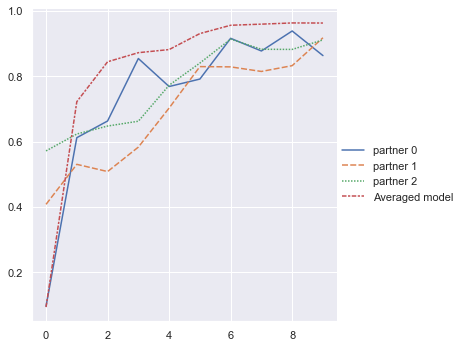

In [7]:
x= current_scenario.mpl.score_matrix_per_partner

x_collective = current_scenario.mpl.score_matrix_collective_models

x = x[:,:,0]
x_collective = x_collective[:,0]


d = {
    'partner 0' : x[:,0],
    'partner 1' : x[:,1],
    'partner 2' : x[:,2],
    'Averaged model' : x_collective
}

df = pd.DataFrame(d)


sns.relplot(data = df, kind = "line")



Aggregated model stills perform a bit better than every individual model.

### Now let look at contributivity scores

We have set our scenario with Shapley values as a contributivity measurement method.

While being quite heavy on computing resources, it provides a great measuring tool.

In [8]:
contributivity_score = current_scenario.contributivity_list

In [9]:
print(contributivity_score[0])


Shapley
Computation time: 0:54:40.343100
Number of characteristic function computed: 7
Contributivity scores: [0.19808334 0.38588333 0.38653332]
Std of the contributivity scores: [0. 0. 0.]
Normalized contributivity scores: [0.20410442 0.39761292 0.39828266]



Since we have artificially set our first partner to only have .1% of the total data set, it obviously contributes less in the final model.

Because we are using the MNIST dataset, even with .1% of the total data, the model is still able to perform reasonably well according to our Accuracy values